In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

/home/deadhand/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
titanic_train = pd.read_csv("../data/train.csv")
titanic_test = pd.read_csv("../data/test.csv")

In [3]:
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

I'm taking out the names for now

In [4]:
X_train = titanic_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']]
y_train = titanic_train['Survived']

X_test = titanic_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']]

In [5]:
# Cabin is a bit unwieldy. I'm going to just take the general area.
# "U" means unknown

X_train.loc[:, 'Cabin'].fillna('U', inplace = True)
X_train.loc[:, 'Cabin'] = X_train.loc[:, 'Cabin'].apply(lambda n: n[0])

X_test.loc[:, 'Cabin'].fillna('U', inplace = True)
X_test.loc[:, 'Cabin'] = X_test.loc[:, 'Cabin'].apply(lambda n: n[0])

/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
# There are also missing values in Embarked

X_train.loc[:, 'Embarked'].fillna('U', inplace = True)
X_test.loc[:, 'Embarked'].fillna('U', inplace = True)

/home/deadhand/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [7]:
X_train['Embarked'].describe()
X_test['Embarked'].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

In [8]:
# I tried to bin Age but wasn't able to find anything that improved cross-validation

X_train_Age = pd.qcut(X_train.Age, 5)

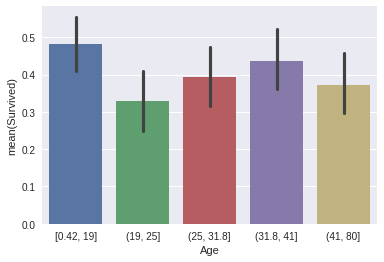

In [9]:
df_train = pd.DataFrame({'Age': X_train_Age,
                         'Survived': y_train})

sns.barplot(x="Age", y="Survived", data=df_train)

In [10]:
categories_to_encode = ['Embarked', 'Cabin', 'Sex']

for category in categories_to_encode:
    labels = LabelEncoder()
    X_train[category] = labels.fit_transform(X_train[category])
    X_test[category] = labels.transform(X_test[category])

/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/deadhand/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
mean_imputer = Imputer(strategy='mean')
X_train = mean_imputer.fit_transform(X_train)
X_test = mean_imputer.transform(X_test)
# Would use MICE, but I'm getting compiler errors

In [12]:
one_hot = OneHotEncoder(handle_unknown = 'ignore')
X_train = one_hot.fit_transform(X_train)
X_test = one_hot.transform(X_test)

In [14]:
# This makes a big difference for SVC and KNN but not the others
# RF and XGB are feature invariant and maybe RC is regularizing 
# the scaled features?
X_train = X_train.toarray()
X_train = X_train.toarray()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:


# X_train = pd.get_dummies(X_train, drop_first=True)
# X_test = pd.get_dummies(X_test, drop_first=True)
# Need Drop first for to remove multicolinearity

In [ ]:
?OneHotEncoder

# Let's get a baseline with a few common models

In [15]:
ridge = RidgeClassifier()
accuracy_scorer = make_scorer(accuracy_score)
cross_val_score(ridge, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()
# This is decent enough baseline

0.79465270684371814

In [16]:
xgb = xg.XGBClassifier()
cross_val_score(xgb, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()

0.81925802973555784

In [17]:
random_forest = RandomForestClassifier()
cross_val_score(random_forest, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()

0.7957751674043807

In [18]:
svc = SVC()
cross_val_score(svc, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()

0.79244211780728624

In [19]:
knn = KNeighborsClassifier()
cross_val_score(knn, X_train, y_train, scoring=accuracy_scorer, cv = 10).mean()

0.66895613437748269

### Possible TODOs

- Get MICE working for imputation
- Work with names and cabins
- Hyperparameter optimization
- Make a submission